# **Setting & Introduction**

## **1. Github 연동**

In [1]:
""" github 연동 """
# !git clone https://github.com/ku-sungsukim/2025-LGElec-Day4.git ### colab 사용시

' github 연동 '

## **2. About Jupyter Notebook**

In [2]:
""" 장표 보여주기용 패키지 Load """
from IPython.display import Image

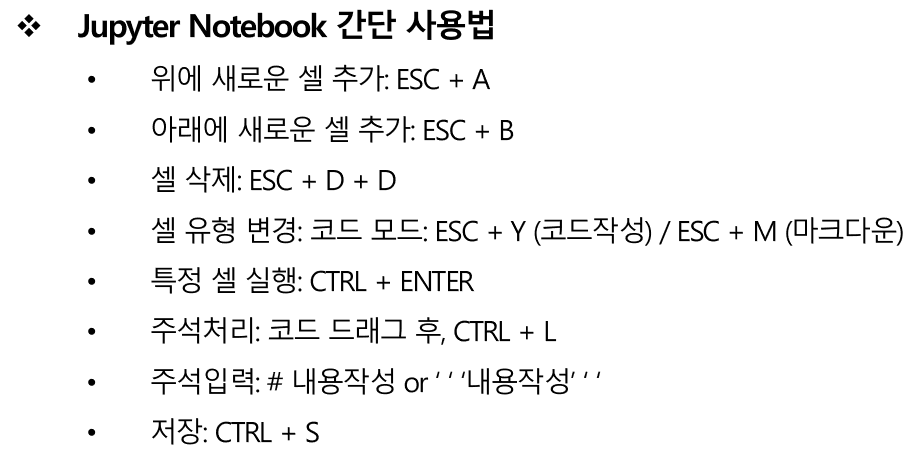

In [3]:
""" 설명 장표 불러오기 """
Image('image/image2.PNG') ### 로컬 사용시
# Image('/content/2025-LGElec-Day4/image/image2.PNG') ### colab 사용시

# **실습**

#### **1. 데이터 불러오기 및 전처리**
 - 데이터 개요 파악 및 전처리

 - 탐색적 데이터 분석

 - 학습/평가데이터 분할

#### **2. 모델링**
 - ARIMA

 - SARIMA

 - AUTO ARIMA & SARIMA

 - Prophet

## **0. 필요 패키지 불러오기**

In [4]:
""" 필요 패키지 설치 """
# !pip install pmdarima

' 필요 패키지 설치 '

In [5]:
""" 데이터 전처리 관련 패키지 """
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


""" 기계학습 모델 구축 및 평가 패키지 """
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).reshape(-1), np.array(y_pred).reshape(-1)
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


""" 데이터 시각화 패키지 """
import matplotlib.pyplot as plt
%matplotlib inline


""" 경고 숨기기 """
import warnings
warnings.filterwarnings(action='ignore') 

c:\Users\korea\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## **1. 데이터 불러오기 및 전처리**
 - 분석데이터: Airpassenger 데이터셋 (월별 비행기 승객 수)

#### **1-1. 데이터 개요 파악 및 전처리**

In [6]:
""" 데이터 불러오기 """

"""
데이터 개요
 - 관측치 개수: 144개
 - 변수 개수: 2개
 
주요 변수 정보
 - Month: 일자
 - #Passenger: 승객수
"""

data = pd.read_csv('data/Airpassengers.csv') ### 로컬 사용시
# data = pd.read_csv('/content/2025-LGElec-Day4/data/AirPassengers.csv') ### colab 사용시

data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [7]:
""" 간단한 데이터 전처리 """

""" 변수명 변경 """
data = data.rename(columns={'Month':'month', '#Passengers':'passengers'})

""" timestep을 index로 지정"""
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data 

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


#### **1-2. 탐색적 데이터 분석**

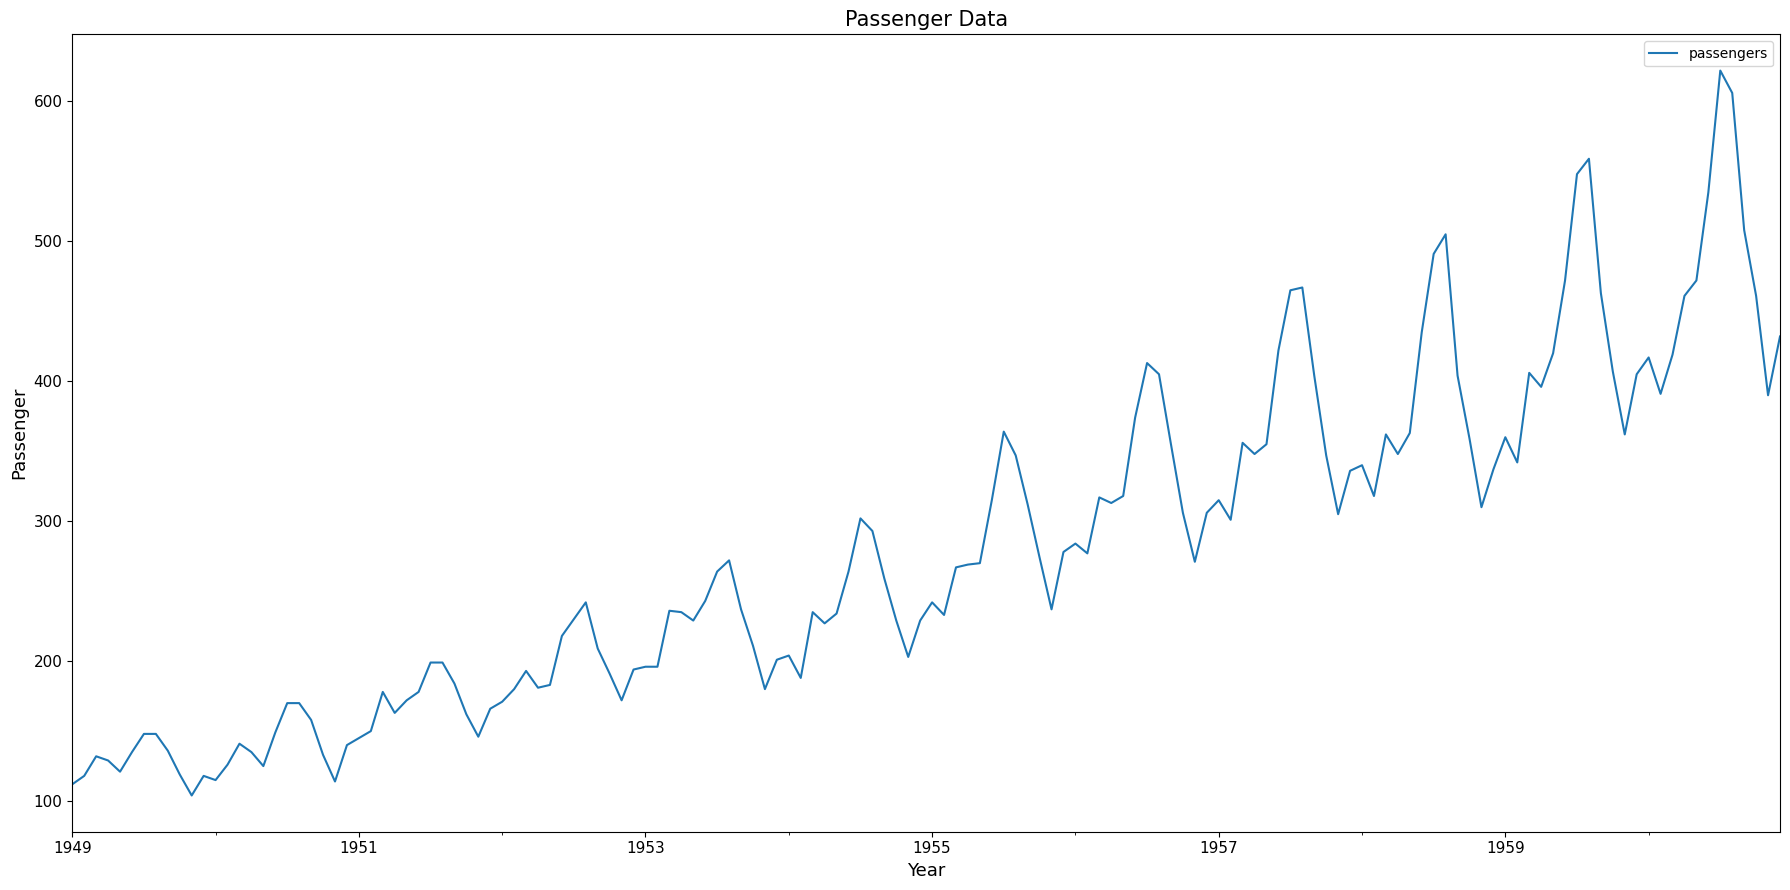

In [8]:
""" 데이터 시각화를 통해 전체 데이터 파악 """
data.plot(figsize=(18, 9)) 

plt.xticks(fontsize=11) ### x축 눈금 크기
plt.yticks(fontsize=11)

plt.title('Passenger Data', fontsize=15) ### Figure명
plt.xlabel('Year', fontsize=13) ### x축 레이블명
plt.ylabel('Passenger', fontsize=13)
plt.tight_layout()
plt.show()

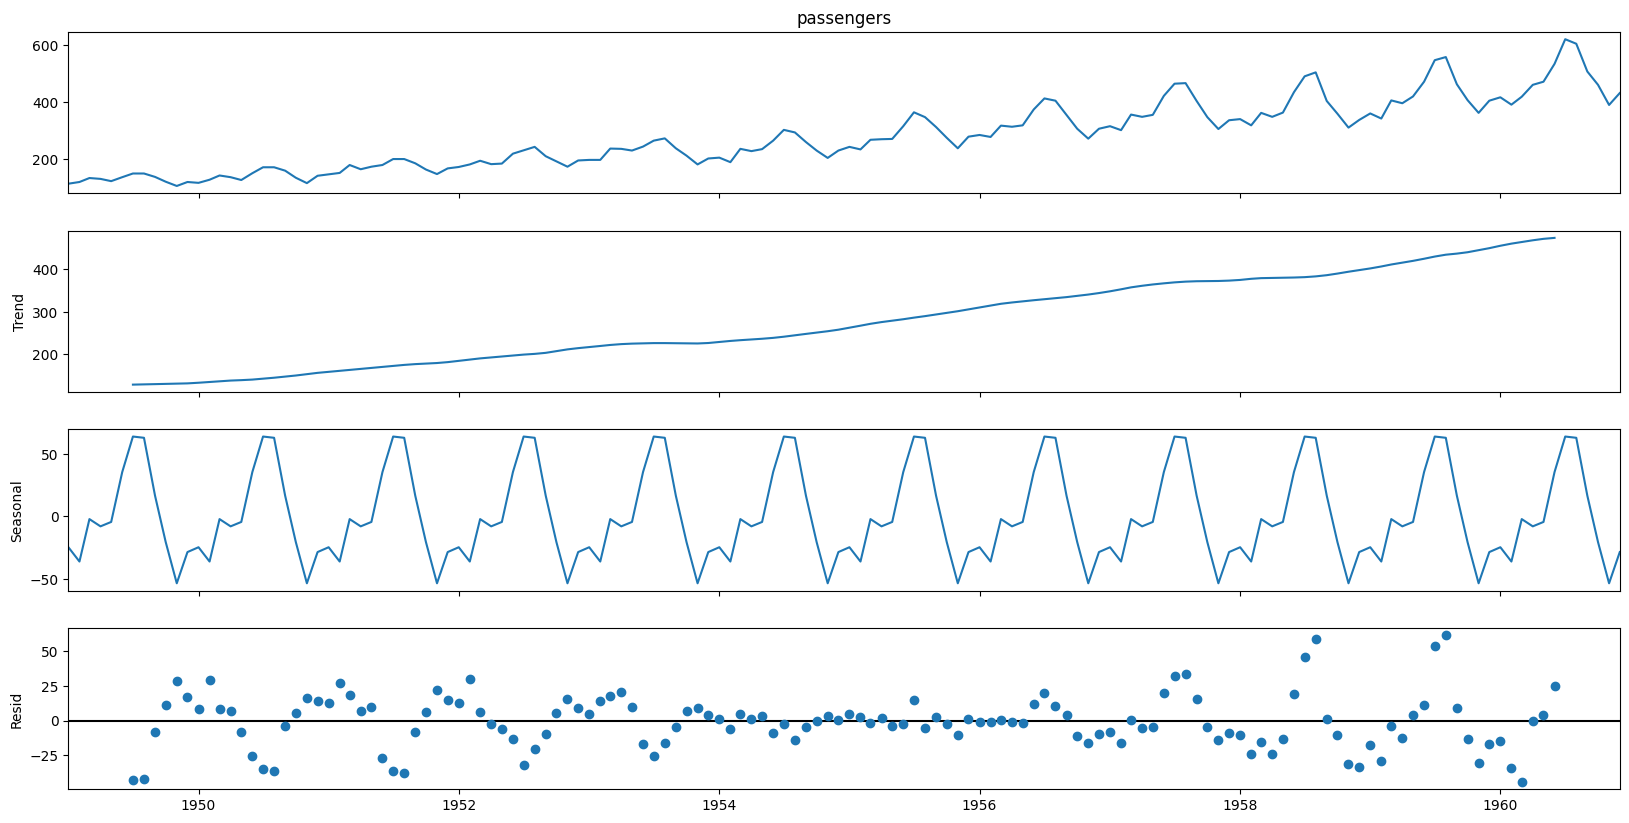

In [9]:
""" 탐색적 데이터 분석: 시계열 분해 """

"""
시계열 데이터를 [추세(Trend)변동 + 계절(Seasonal)변동 + 우연(Random)변동]으로 구분
"""

decomposition = sm.tsa.seasonal_decompose(data['passengers'],  model='additive')

fig = decomposition.plot()
fig.set_size_inches(18, 9)
plt.show()

#### **1-3. 학습/평가 데이터 분할**

In [10]:
""" 학습/평가데이터 분할 """

"""
시계열 데이터는 시계열을 기준으로 분할하는 것이 일반적
 - shuffle=False 적용 시, 데이터를 섞지 않고, index 단위로 구분하기에 시계열 데이터 속성을 반영하여 분할 가능
 - 분할비율: 70% vs 30%
"""

train, test = train_test_split(data, test_size=0.3, shuffle=False)
train.shape, test.shape

((100, 1), (44, 1))

## **2. 모델링**

#### **2-1. ARIMA**
 - "추세" 반영

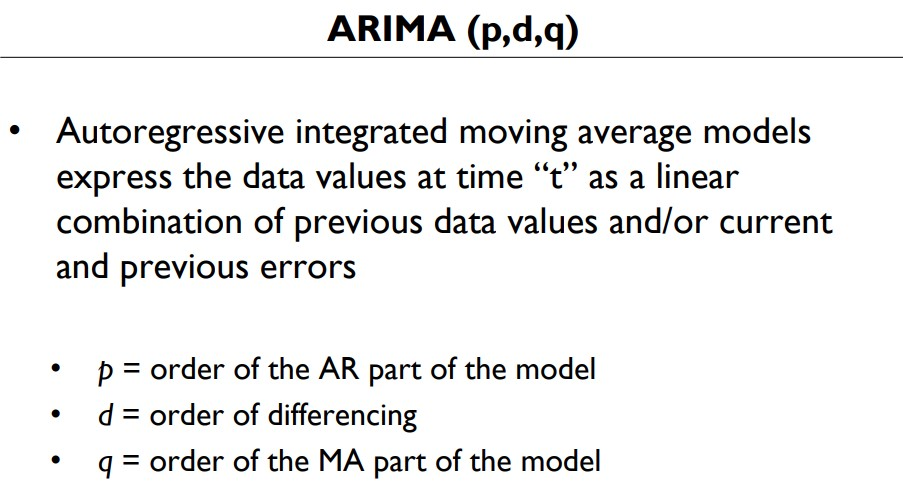

In [11]:
""" 설명 장표 불러오기 """
Image('image/image10.PNG') ### 로컬 사용시
# Image('/content/2025-LGElec-Day4/image/image10.PNG') ### colab 사용시

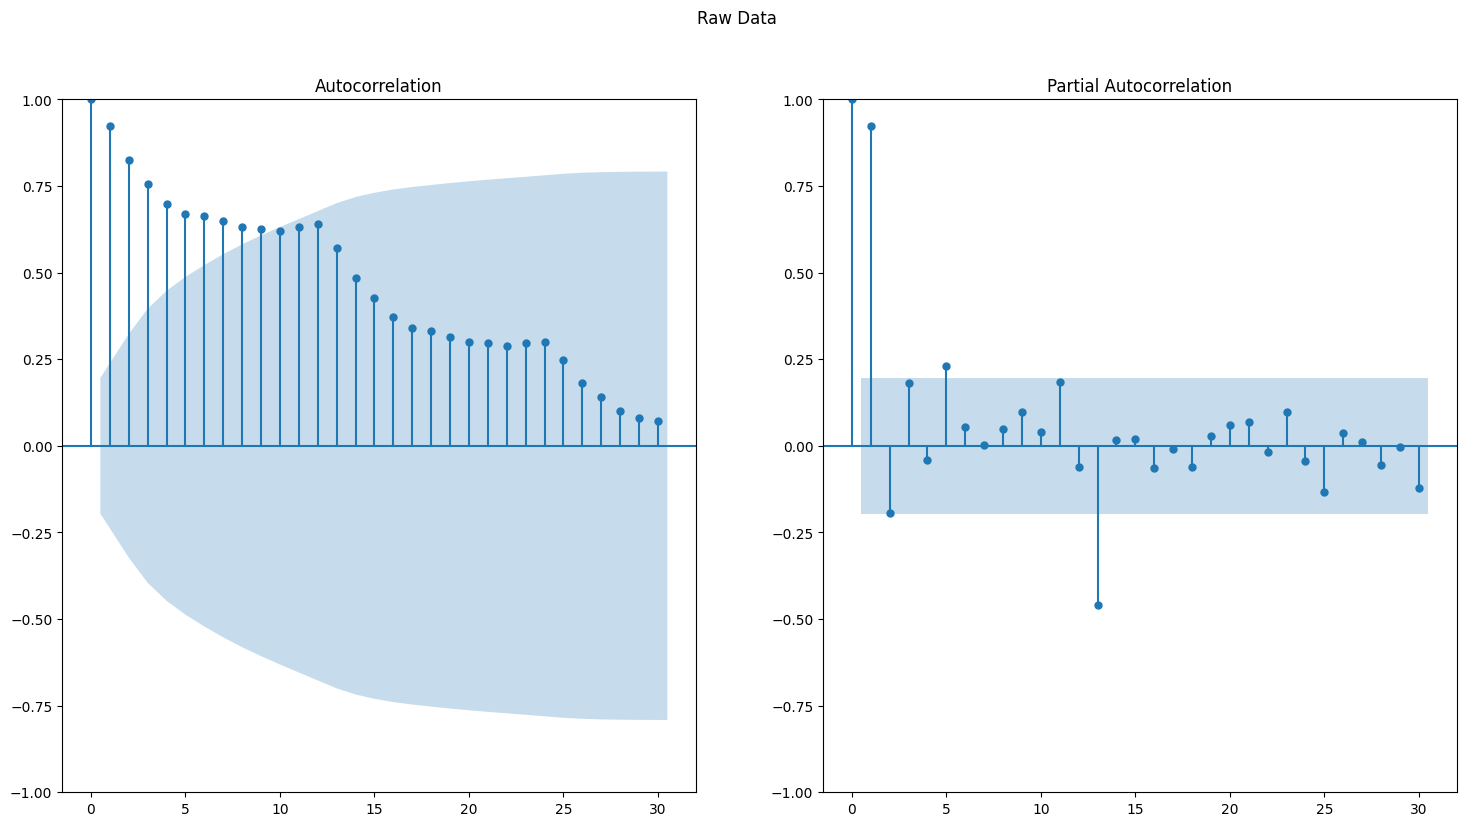

In [12]:
""" 정상성 확인 """

"""
ACF 그래프가 상/하로 크게 진동하는 것이 아닌, 부드러운 형태 --> 비정상성
"""

fig, ax = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=30, ax=ax[0]) ### ACF 그래프 시각화
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=30, ax=ax[1]); ### PACF 그래프 시각화

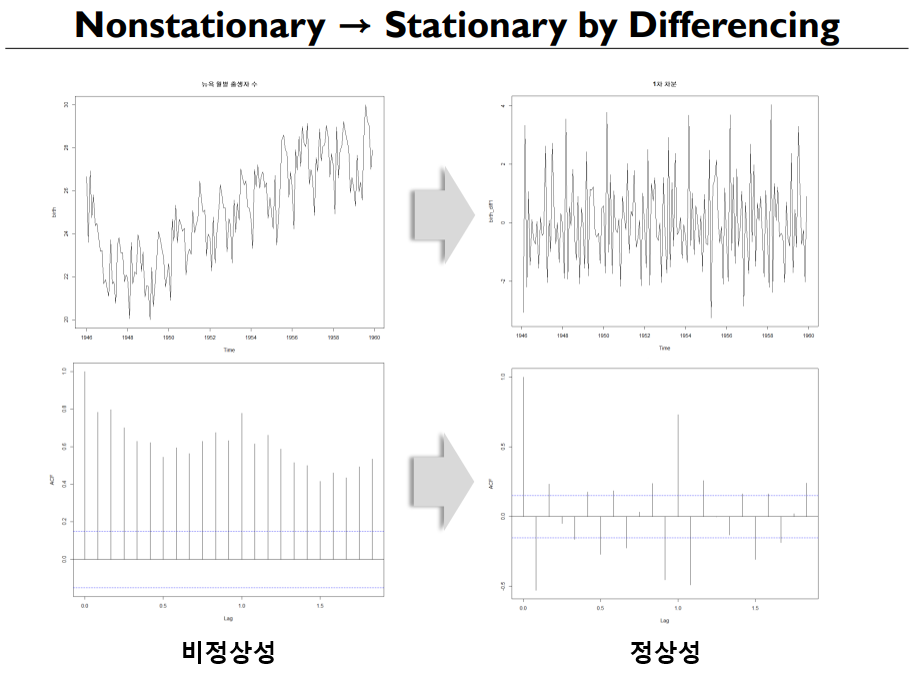

In [13]:
""" 설명 장표 불러오기 """
Image('image/image11.PNG') ### 로컬 사용시
# Image('/content/2025-LGElec-Day4/image/image11.PNG') ### colab 사용시

In [14]:
""" 1차차분 수행 """
 
"""
차분: 비정상성을 정상성으로 바꾸기 위함
 - 1차 차분 후, 정상성 여부 파악
 - 만약, 여전히 비정상성이라면, 차분 1회 더 수행
"""

diff_train = train['passengers'].diff(periods=1) ### 차분 수행 (period: 차분 길이)
diff_train = diff_train.dropna(axis=0) ### 차분 시 생기는 결측행 제거
print('####### Raw Data #######')
print(train)
print('\n\n### Differenced Data ###')
print(diff_train)

####### Raw Data #######
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1956-12-01         306
1957-01-01         315
1957-02-01         301
1957-03-01         356
1957-04-01         348

[100 rows x 1 columns]


### Differenced Data ###
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1956-12-01    35.0
1957-01-01     9.0
1957-02-01   -14.0
1957-03-01    55.0
1957-04-01    -8.0
Name: passengers, Length: 99, dtype: float64


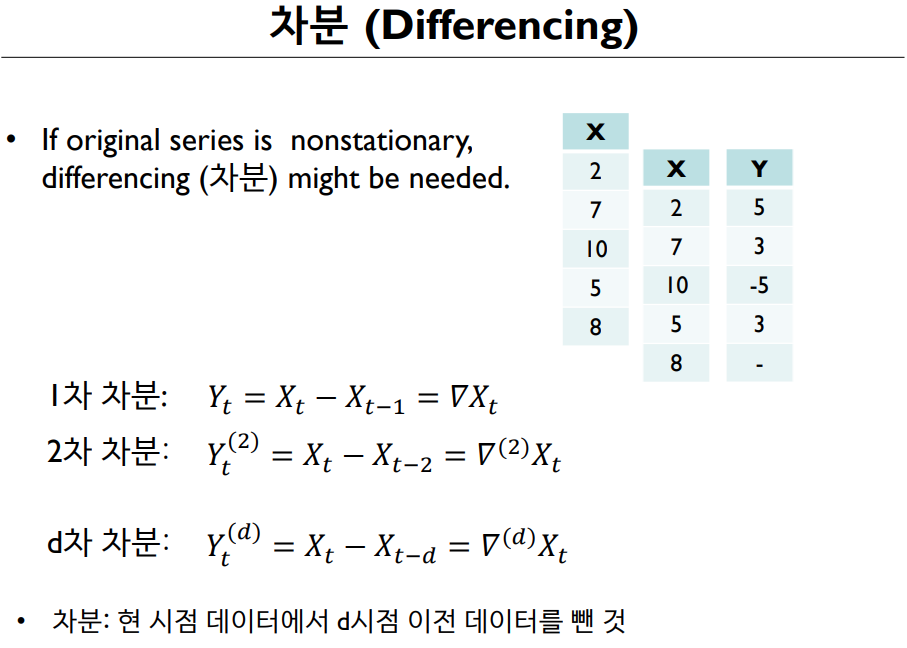

In [15]:
""" 설명 장표 불러오기 """
Image('image/image12.PNG') ### 로컬 사용시
# Image('/content/2025-LGElec-Day4/image/image12.PNG') ### colab 사용시

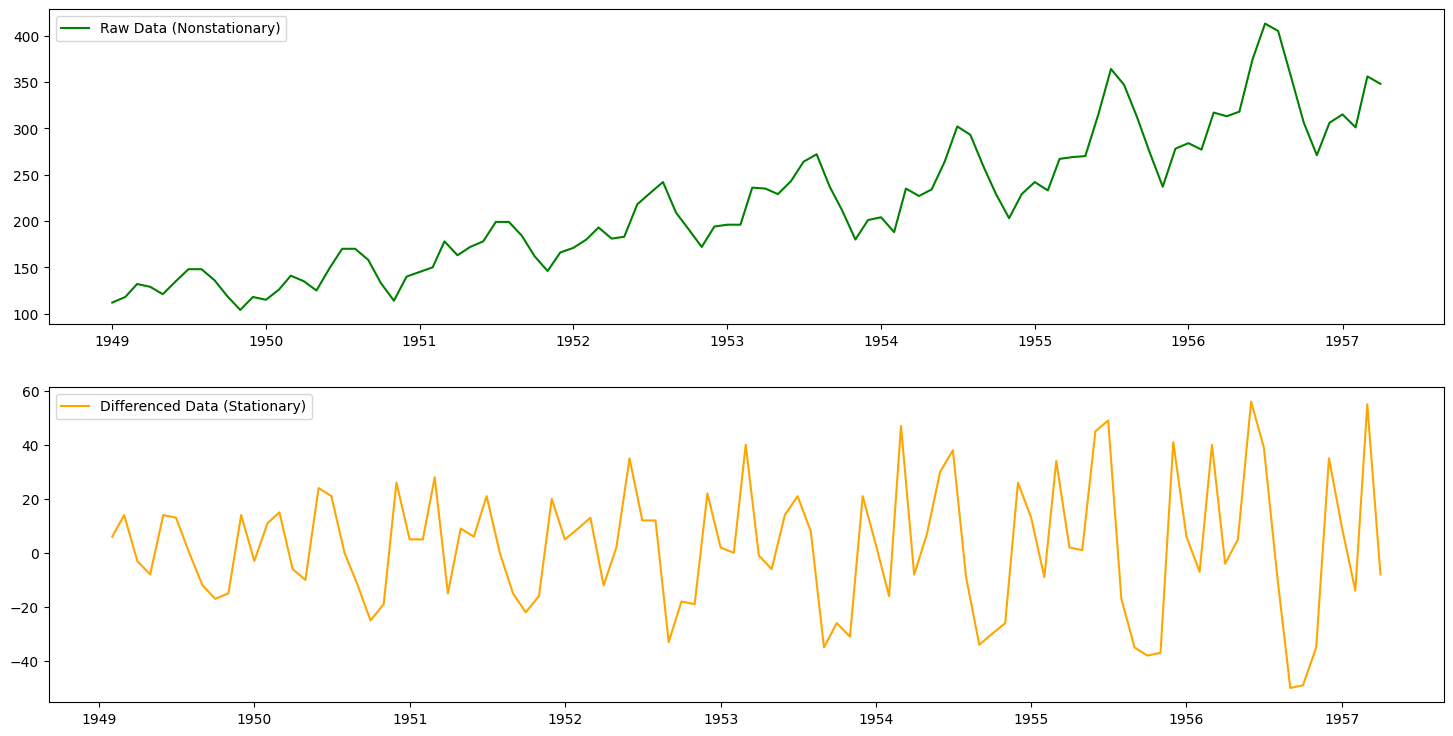

In [16]:
""" 1차차분 결과 시각화 """
plt.figure(figsize=(18, 9))

plt.subplot(211)
plt.plot(train['passengers'], 'green') ### 기존 데이터를 초록색으로 시각화
plt.legend(['Raw Data (Nonstationary)'])

plt.subplot(212)
plt.plot(diff_train, 'orange') ### 1차차분 데이터를 오렌지색으로 시각화
plt.legend(['Differenced Data (Stationary)'])
plt.show()

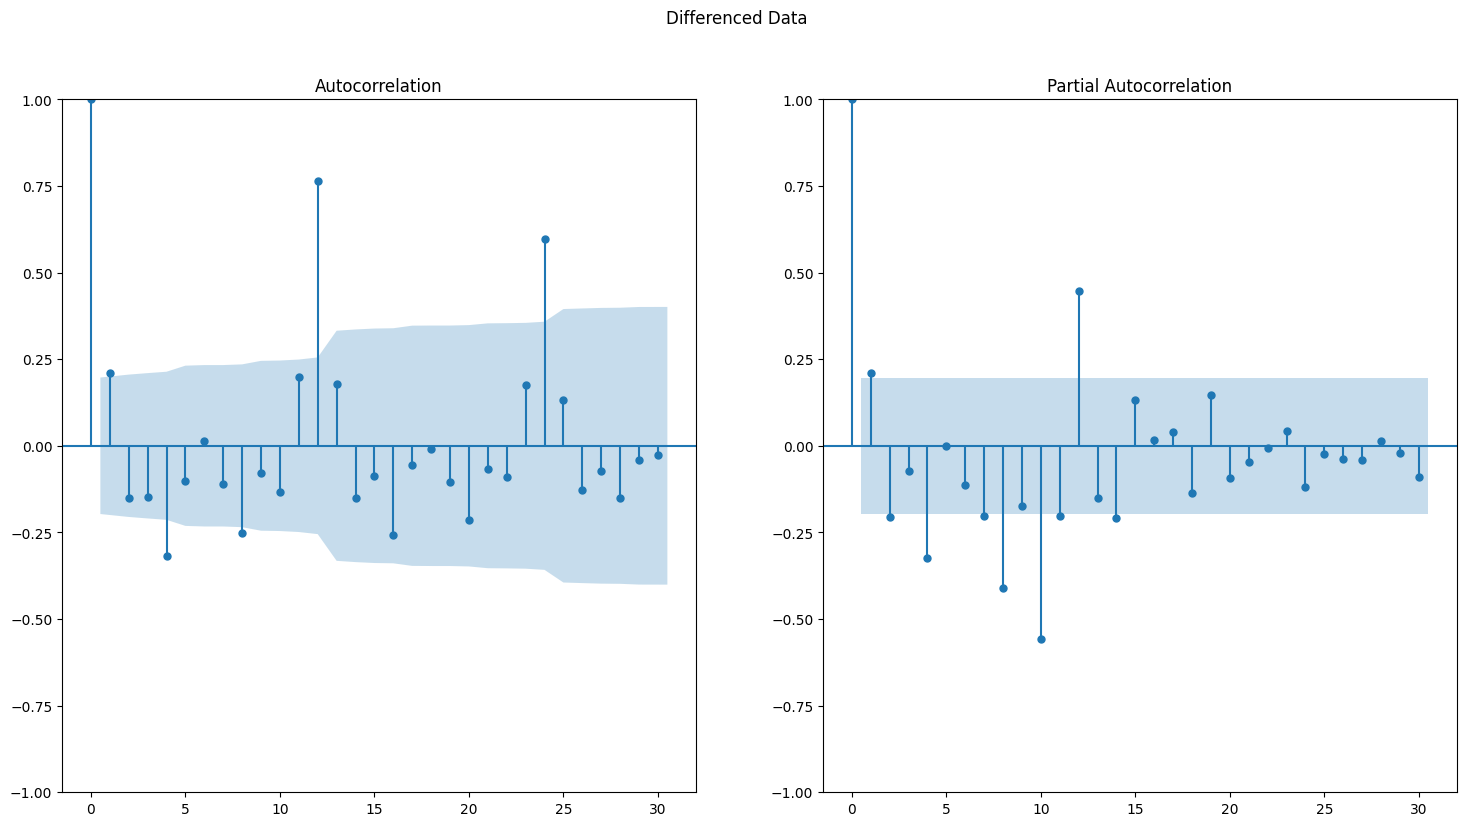

In [17]:
""" 1차차분 결과 정상성 파악 """

"""
ACF가 부드럽지 않게 변화
 - 기존 비정상성 데이터를 정상성으로 변환 완료
"""

fig, ax = plt.subplots(1, 2, figsize=(18, 9)) 
fig.suptitle('Differenced Data') 
sm.graphics.tsa.plot_acf(diff_train.values.squeeze(), lags=30, ax=ax[0]) ### ACF 그래프 시각화
sm.graphics.tsa.plot_pacf(diff_train.values.squeeze(), lags=30, ax=ax[1]); ### PACF 그래프 시각화

In [18]:
""" ARIMA 적합 방법 예시 """

"""
ARIMA(2, 1, 2) 적합
1. 1차차분 수행 (d=1)
2. 1차 차분 결과 ACF 및 PACF가 lag2 시점에서 모두 cutoff
 - ARMA(2, 2) 
  --- ACF --> MA(2)
  --- PACF --> AR(2)
"""

ARIMA_model = ARIMA(train.values, order=(2, 1, 2)) ### order: (p, d, q)
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -443.217
Date:                Mon, 03 Mar 2025   AIC                            896.434
Time:                        15:12:14   BIC                            909.409
Sample:                             0   HQIC                           901.684
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2466      0.159      1.555      0.120      -0.064       0.557
ar.L2          0.2464      0.214      1.153      0.249      -0.172       0.665
ma.L1         -0.0336      0.108     -0.310      0.757      -0.246       0.179
ma.L2         -0.7168      0.143     -5.012      0.000      -0.997      -0.437
sigma2       449.6315     81.282      5.532      0.000     290.322     608.941
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.34
Prob(Q):                              0.97   Prob(JB):                         0.31
Heteroskedasticity (H):               3.45   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
""" ARIMA 파라미터 탐색 """

"""
일일이 시각화를 해보며 최적의 파라미터를 찾는 것도 좋지만, 최근에는 컴퓨팅 성능이 향상되어 많은 경우의 수를 직접 모델링하는 것도 큰 시간이 소요되지 않음
 - 아래 범위에 대해 모두 모델링 수행 후, 최적 AIC값이 나오는 파라미터로 최종 모델링 수행
  1) p: 0~2
  2) d: 1~2
  3) q: 0~2
"""

""" 범위 정의 """
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q)) ### 모든 (p, d, q)범위 고려

""" 파라미터 탐색 """
aic_list = []
for i in pdq:
    model = ARIMA(train.values, order=(i))
    ARIMA_model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(ARIMA_model_fit.aic, 2)}')
    aic_list.append(round(ARIMA_model_fit.aic, 2))

ARIMA: (0, 1, 0) >> AIC : 908.78
ARIMA: (0, 1, 1) >> AIC : 903.55
ARIMA: (0, 1, 2) >> AIC : 899.47
ARIMA: (1, 1, 0) >> AIC : 906.03
ARIMA: (1, 1, 1) >> AIC : 898.91
ARIMA: (1, 1, 2) >> AIC : 895.89
ARIMA: (2, 1, 0) >> AIC : 903.75
ARIMA: (2, 1, 1) >> AIC : 896.37
ARIMA: (2, 1, 2) >> AIC : 896.43


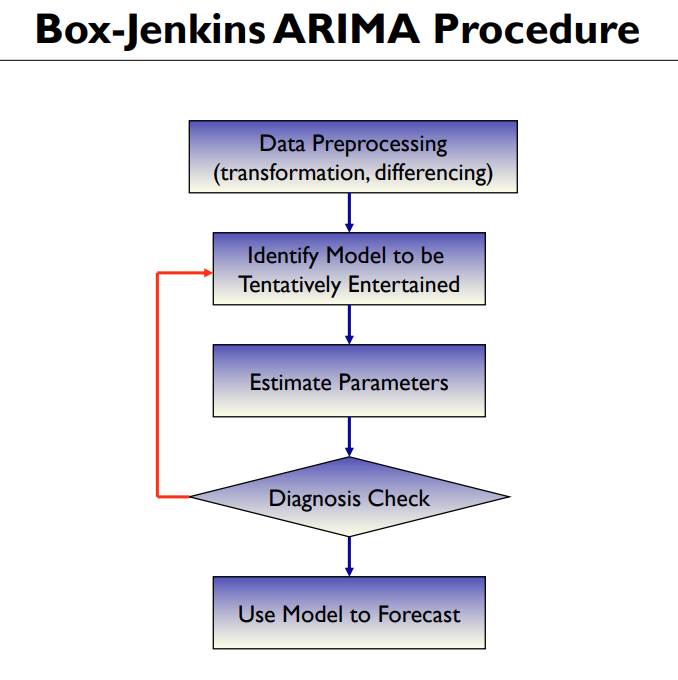

In [20]:
""" 설명 장표 불러오기 """
Image('image/image13.PNG') ### 로컬 사용시
# Image('/content/2025-LGElec-Day4/image/image13.PNG') ### colab 사용시

In [21]:
""" 최소 AIC를 만족하는 (p, d, q) 식별 """
ARIMA_optimal = [(pdq[i], j) for i, j in enumerate(aic_list) if j == min(aic_list)]
ARIMA_optimal_pdq = ARIMA_optimal[0][0] ### (p, d, q)값
ARIMA_optimal_AIC = ARIMA_optimal[0][1] ### 해당 (p, d, q)일 때, AIC값
print(f'Optimal (p, d, q): {ARIMA_optimal_pdq}')
print(f'Optimal AIC: {ARIMA_optimal_AIC}')

Optimal (p, d, q): (1, 1, 2)
Optimal AIC: 895.89


In [22]:
""" 최적의 파라미터로 ARIMA 모델 적합 """
ARIMA_model_opt = ARIMA(train.values, order=ARIMA_optimal_pdq)
ARIMA_model_opt_fit = ARIMA_model_opt.fit()

ARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -443.946
Date:                Mon, 03 Mar 2025   AIC                            895.892
Time:                        15:12:14   BIC                            906.272
Sample:                             0   HQIC                           900.092
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4654      0.133      3.489      0.000       0.204       0.727
ma.L1         -0.2326      0.141     -1.653      0.098      -0.508       0.043
ma.L2         -0.5172      0.099     -5.224      0.000      -0.711      -0.323
sigma2       456.8414     83.534      5.469      0.000     293.118     620.565
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 3.74
Prob(Q):                              0.49   Prob(JB):                         0.15
Heteroskedasticity (H):               3.72   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
""" ARIMA 모델 Test기간 예측 """
ARIMA_prediction = ARIMA_model_opt_fit.get_forecast(len(test))
ARIMA_test_pred = ARIMA_prediction.predicted_mean
ARIMA_test_pred

array([323.39487212, 324.8074291 , 325.46490092, 325.77091985,
       325.91335575, 325.97965226, 326.01050983, 326.02487243,
       326.03155747, 326.03466901, 326.03611727, 326.03679136,
       326.03710511, 326.03725115, 326.03731912, 326.03735076,
       326.03736548, 326.03737234, 326.03737553, 326.03737701,
       326.0373777 , 326.03737802, 326.03737817, 326.03737824,
       326.03737828, 326.03737829, 326.0373783 , 326.0373783 ,
       326.0373783 , 326.0373783 , 326.0373783 , 326.0373783 ,
       326.0373783 , 326.0373783 , 326.0373783 , 326.0373783 ,
       326.0373783 , 326.0373783 , 326.0373783 , 326.0373783 ,
       326.0373783 , 326.0373783 , 326.0373783 , 326.0373783 ])

In [24]:
""" ARIMA 모델 평가 """
print(f'MSE: {np.round(mean_squared_error(test, ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, ARIMA_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')

MSE: 14889.77
RMSE: 122.02
MAE: 97.19
MAPE: 20.84
R2 score: -1.55


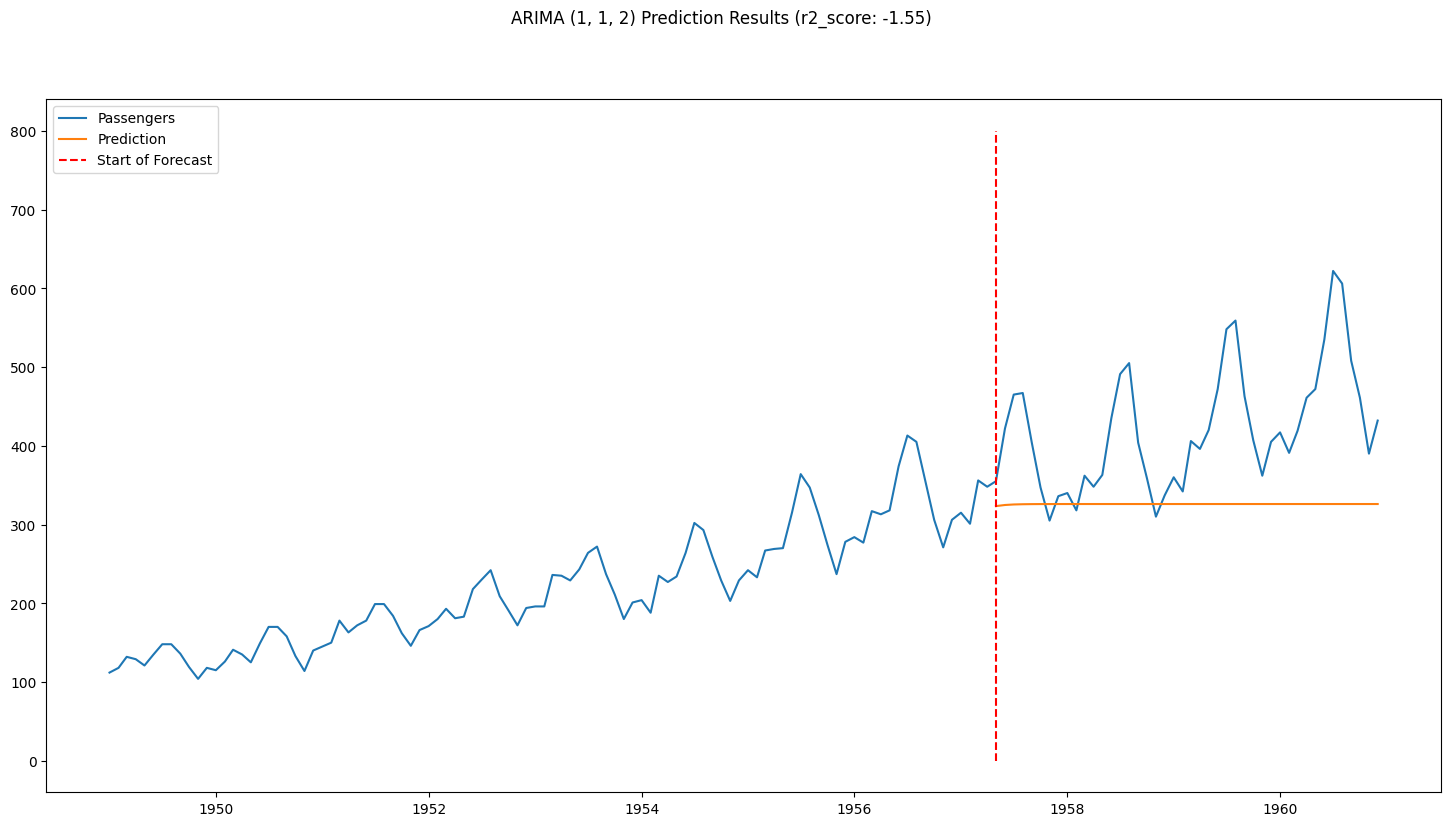

In [25]:
""" ARIMA 시각화 """
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(data.index, data.values, label = 'Passengers') ### 기존 데이터 시각화
ax.plot(test.index, ARIMA_test_pred, label = 'Prediction') ### test 예측 결과 시각화

ax.vlines(datetime.datetime.strptime('1957-05-01','%Y-%m-%d'), ymin=0, ymax=800, linestyle='--', color='r', label='Start of Forecast') ### train/test 분리시점 시각화
ax.legend(loc='upper left') ### 범례 지정
plt.suptitle(f'ARIMA {ARIMA_optimal_pdq} Prediction Results (r2_score: {np.round(r2_score(test, ARIMA_test_pred), 2)})') ### Figure 제목 지정
plt.show()

#### **2-2. SARIMA**
 - "추세 + 계절성" 반영 (ARIMA에 계절성을 반영)

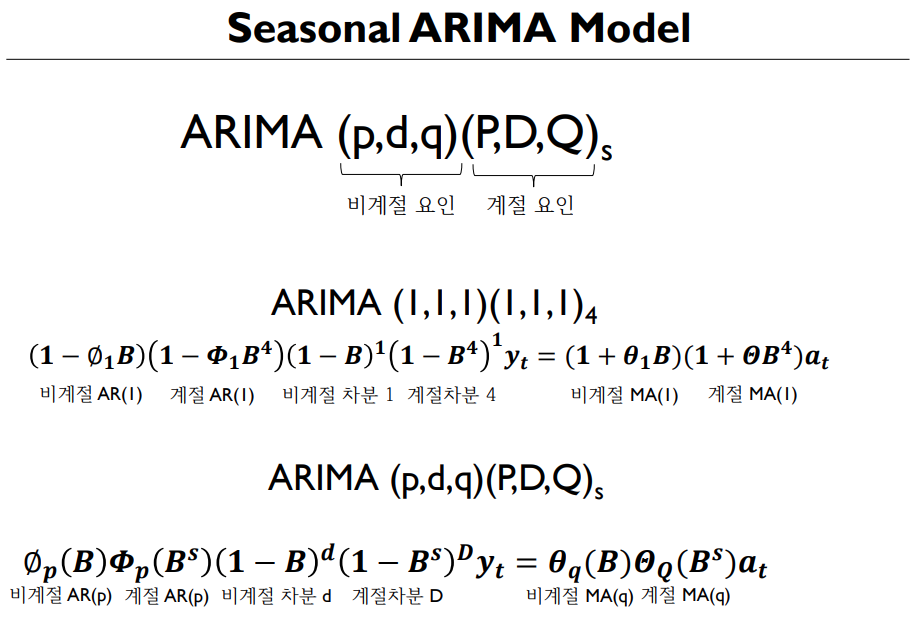

In [26]:
""" 설명 장표 불러오기 """
Image('image/image14.PNG') ### 로컬 사용시
# Image('/content/2025-LGElec-Day4/image/image14.PNG') ### colab 사용시

In [27]:
""" SARIMA 파라미터 탐색 """

"""
ARIMA와 마찬가지로 다양한 범위에서 파라미터 서칭
 - 아래 범위에 대해 모두 모델링 수행 후, 최적 AIC값이 나오는 파라미터로 최종 모델링 수행
  1) p: 0~2
  2) d: 1
  3) q: 0~2
  4) seasonal_p: 0~2
  5) seasonal_d: 1
  6) seasonal_q: 0~2
  7) 계졀성 주기(s)는 12로 고정
"""

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q)) ### 모든 (p, d, q) 조합 정리
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] ### 모든 seasonal (P, D, Q) 조합 정리

aic=[]
params=[]
for i in pdq:
    for j in seasonal_pdq:
        model = SARIMAX(train.values, order=(i), seasonal_order = (j))
        model_fit = model.fit()
        print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic, 2)}')
        aic.append(round(model_fit.aic, 2))
        params.append((i, j))  

SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 650.8
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 647.21
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 649.03
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 647.44
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 649.13
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 646.8
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 648.85
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 650.69
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 647.28
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 646.17
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 644.73
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 645.89
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 644.35
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 646.34
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 642.0
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 646.33
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 644.4
SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : 643.02
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 648.15
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 646.71
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 647.86
SARIMA: (0, 1, 2)

In [28]:
""" 최소 AIC를 만족하는 (p, d, q, P, D, Q)범위 식별 """
SARIMA_optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]

SARIMA_optimal_pdq = SARIMA_optimal[0][0][0] ### (p, d, q)값
SARIMA_optimal_seasonal_pdq = SARIMA_optimal[0][0][1] ### seasonal (P, D, Q)값
SARIMA_optimal_AIC = SARIMA_optimal[0][1] ### (p, d, q, P, D, Q)일 때, AIC값
print(f'Optimal (p, d, q): {SARIMA_optimal_pdq}')
print(f'Optimal Seasonal (P, D, Q): {SARIMA_optimal_seasonal_pdq}')
print(f'Optimal AIC: {SARIMA_optimal_AIC}')

Optimal (p, d, q): (0, 1, 1)
Optimal Seasonal (P, D, Q): (1, 1, 2, 12)
Optimal AIC: 642.0


In [ ]:
""" 최적의 파라미터로 SARIMA 모델 적합 """
SARIMA_model_opt = SARIMAX(train.values, order=SARIMA_optimal_pdq, seasonal_order=SARIMA_optimal_seasonal_pdq)
SARIMA_model_opt_fit = SARIMA_model_opt.fit()

SARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -316.000
Date:                                 Mon, 03 Mar 2025   AIC                            641.999
Time:                                         15:12:37   BIC                            654.329
Sample:                                              0   HQIC                           646.964
                                                 - 100                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3153      0.097     -3.259      0.001      -0.505      -0.126
ar.S.L12       0.9990      0.330      3.026      0.002       0.352       1.646
ma.S.L12      -1.4942      6.509     -0.230      0.818     -14.251      11.263
ma.S.L24       0.5142      3.167      0.162      0.871      -5.693       6.721
sigma2        64.7758    400.840      0.162      0.872    -720.855     850.407
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.15
Prob(Q):                              0.91   Prob(JB):                         0.21
Heteroskedasticity (H):               1.34   Skew:                             0.47
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
""" SARIMA 모델 Test기간 예측 """
SARIMA_prediction = SARIMA_model_opt_fit.get_forecast(len(test))
SARIMA_test_pred = SARIMA_prediction.predicted_mean
SARIMA_test_pred

array([354.93049429, 408.7514568 , 454.59603709, 443.20368666,
       393.13287249, 346.4293236 , 308.30781912, 346.57474259,
       356.60629483, 341.1100554 , 395.48491864, 390.10671811,
       398.10969535, 456.48654966, 505.92612646, 492.99170903,
       438.58893344, 388.60123256, 347.8933076 , 388.55378521,
       399.60684813, 381.6594298 , 440.09367502, 434.78340172,
       444.23096033, 507.15927477, 560.19035111, 545.7153667 ,
       486.98484352, 433.71618525, 390.4243557 , 433.47605917,
       445.54963911, 425.15342622, 487.64310474, 482.40069259,
       493.29142737, 560.7667746 , 617.38585691, 601.37180408,
       538.31774305, 481.77131888, 435.89809818, 481.33870149])

In [31]:
""" SARIMA 모델 평가 """
print(f'MSE: {np.round(mean_squared_error(test, SARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, SARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA_test_pred), 2)}')

MSE: 865.69
RMSE: 29.42
MAE: 25.57
MAPE: 6.4
R2 score: 0.85


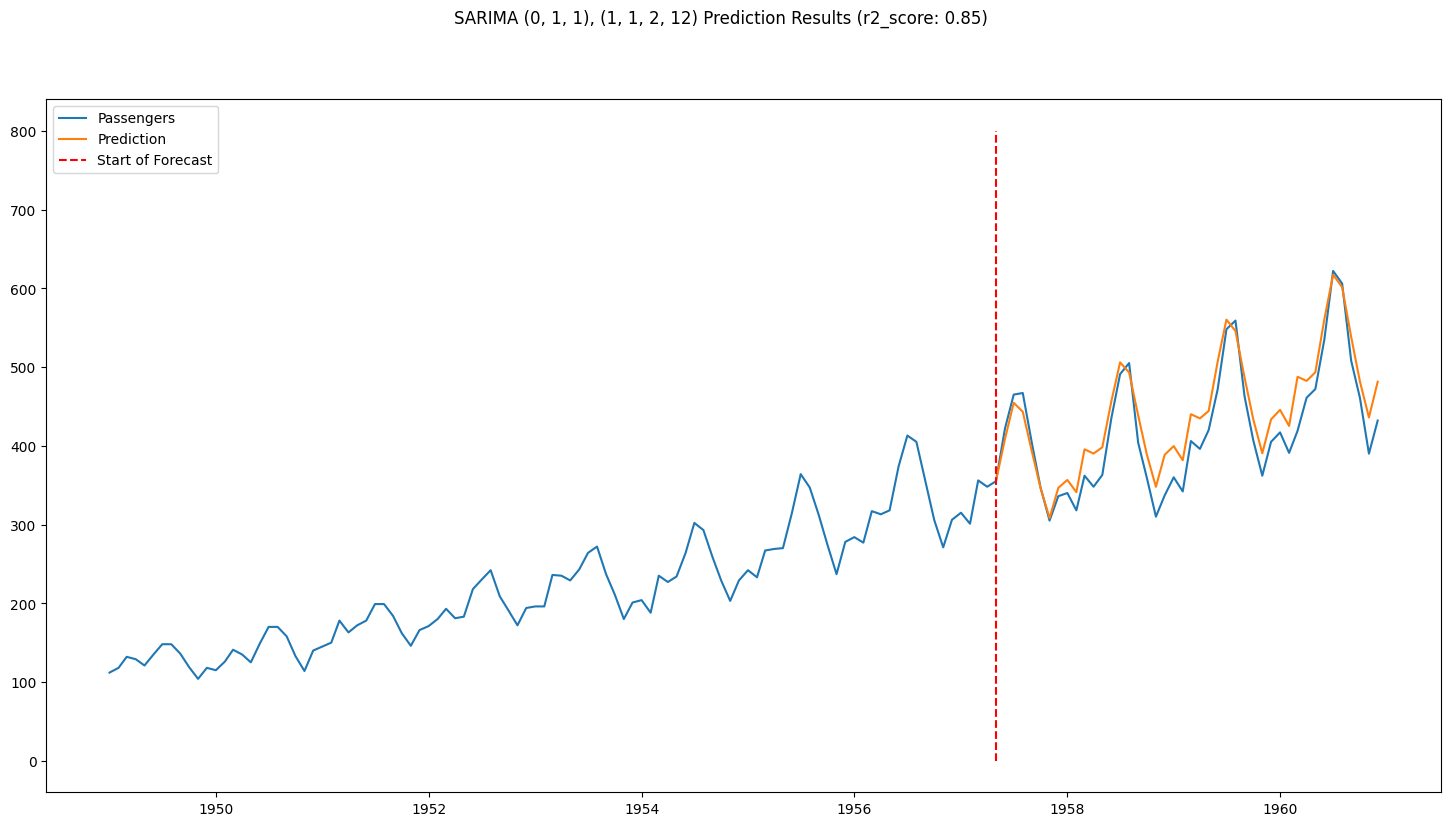

In [32]:
""" SARIMA 시각화 """
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(data.index, data.values, label = 'Passengers') ### 기존 데이터 시각화
ax.plot(test.index, SARIMA_test_pred, label = 'Prediction') ### test 예측 결과 시각화

ax.vlines(datetime.datetime.strptime('1957-05-01','%Y-%m-%d'), ymin=0, ymax=800, linestyle='--', color='r', label='Start of Forecast') ### train/test 분리시점 시각화
ax.legend(loc='upper left') ### 범례 지정
plt.suptitle(f'SARIMA {SARIMA_optimal_pdq}, {SARIMA_optimal_seasonal_pdq} Prediction Results (r2_score: {np.round(r2_score(test, SARIMA_test_pred), 2)})') ### Figure 제목 지정
plt.show()

#### **2.3 AUTO ARIMA & SARIMA (Simple Version)**

In [33]:
""" ARIMA 또는 SARIMA 모델링 """

"""
auto_arima 패키지를 활용하여 파라미터 탐색 및 모델 피팅까지 한번에 가능
 - start_p, q, P, Q: 서칭할 파라미터의 최소값
 - max_p, q, P, Q: 서칭할 파라미터의 최대값
 - d, D: 차분
 - trace, error_action, suppress_warnings: log 및 warning 관련

패키지 별 차이로, 약간의 성능 차이 존재 (statamodel vs pmdarima)
"""

SARIMA2 = auto_arima(y=train, 
                     start_p=0, start_q=0, max_p=2, max_q=2, d=1, ### ARIMA parameters
                     seasonal=True, ### ARIMA or SARIMA?
                     start_P=0, start_Q=0, max_P=2, max_Q=2, D=1, m=12, ### SARIMA parameters
                     trace=True,
                     error_action='ignore',  
                     suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=650.796, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=644.203, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=644.733, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=645.995, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=646.172, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=646.187, Time=0.08 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.600, Time=0.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=647.442, Time=0.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=646.085, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=645.647, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=644.346, Time=0.03 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=647.580, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=645.940, Time=0.09 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]

In [34]:
""" SARIMA 적합 결과 확인 """
SARIMA2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -319.101
Date:                            Mon, 03 Mar 2025   AIC                            644.203
Time:                                    15:12:38   BIC                            651.601
Sample:                                01-01-1949   HQIC                           647.182
                                     - 04-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2434      0.097     -2.512      0.012      -0.433      -0.054
ar.S.L12      -0.2127      0.087     -2.432      0.015      -0.384      -0.041
sigma2        89.1842     14.080      6.334      0.000      61.587     116.781
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.97   Prob(JB):                         0.30
Heteroskedasticity (H):               1.32   Skew:                             0.40
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
""" SARIMA2 모델 Test기간 예측 """
SARIMA2_test_pred = SARIMA2.predict(len(test))
SARIMA2_test_pred 

1957-05-01    353.433649
1957-06-01    406.781321
1957-07-01    447.984392
1957-08-01    438.051605
1957-09-01    391.246543
1957-10-01    344.585092
1957-11-01    309.159969
1957-12-01    345.436075
1958-01-01    353.798005
1958-02-01    341.286867
1958-03-01    393.096441
1958-04-01    385.947221
1958-05-01    391.288635
1958-06-01    445.200445
1958-07-01    485.934933
1958-08-01    476.413240
1958-09-01    428.928631
1958-10-01    381.769781
1958-11-01    346.435080
1958-12-01    382.439764
1959-01-01    390.937409
1959-02-01    378.109597
1959-03-01    430.597759
1959-04-01    423.267583
1959-05-01    428.628615
1959-06-01    482.420435
1959-07-01    523.254588
1959-08-01    513.645458
1959-09-01    466.305385
1959-10-01    419.252330
1959-11-01    383.898396
1959-12-01    419.960810
1960-01-01    428.429589
1960-02-01    415.669133
1960-03-01    468.012962
1960-04-01    460.721274
1960-05-01    466.078134
1960-06-01    519.895475
1960-07-01    560.708430
1960-08-01    551.117897


In [36]:
""" SARIMA2 모델 평가 """
print(f'MSE: {np.round(mean_squared_error(test, SARIMA2_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA2_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA2_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA2_test_pred), 2)}')

MSE: 686.75
RMSE: 26.21
MAE: 21.54
MAPE: 20.84
R2 score: 0.88


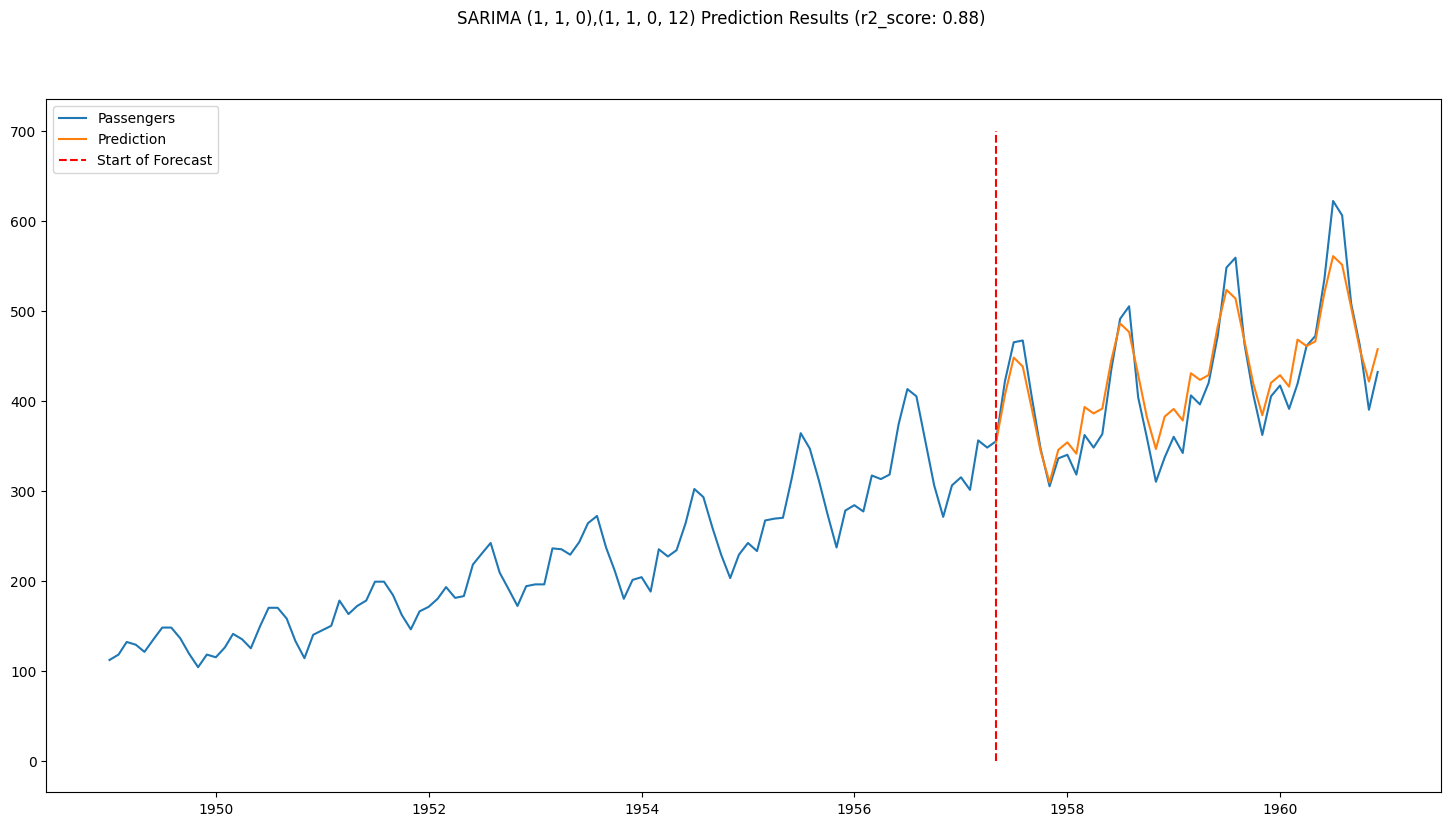

In [37]:
""" SARIMA2 시각화 """
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(data.index, data.values, label = 'Passengers') ### 기존 데이터 시각화
ax.plot(test.index, SARIMA2_test_pred, label = 'Prediction') ### test 예측 결과 시각화

ax.vlines(datetime.datetime.strptime('1957-05-01','%Y-%m-%d'), ymin=0, ymax=700, linestyle='--', color='r', label='Start of Forecast') ### train/test 분리시점 시각화
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {SARIMA2.order},{SARIMA2.seasonal_order} Prediction Results (r2_score: {np.round(r2_score(test, SARIMA2_test_pred), 2)})')
plt.show()

#### **2.4 Prophet**

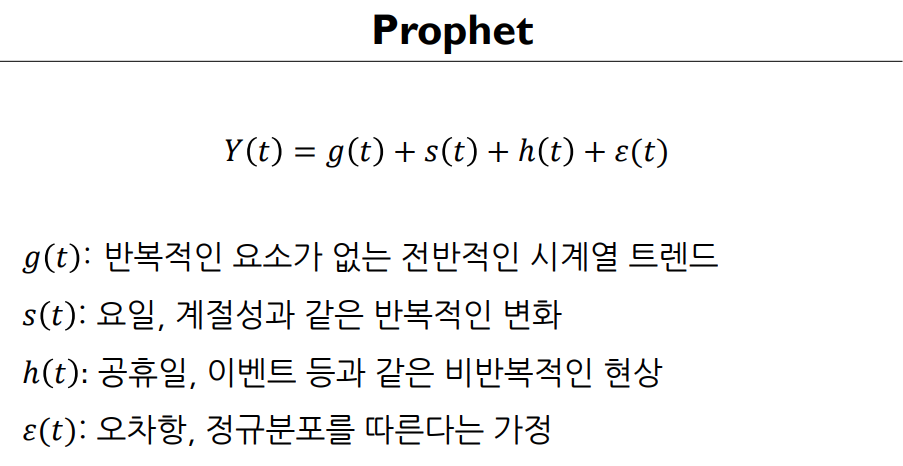

In [38]:
""" 설명 장표 불러오기 """
Image('image/image15.PNG') ### 로컬 사용시
# Image('/content/2025-LGElec-Day4/image/image15.PNG') ### colab 사용시

In [39]:
""" Prophet 모델링을 위한 간단한 전처리 """
train_prophet = train.reset_index()
train_prophet.columns = ['ds', 'y']

test_prophet = test.reset_index()
test_prophet.columns = ['ds', 'y']
train_prophet.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [40]:
""" Prophet 모델 적합 """
Prophet_model = Prophet()
Prophet_model.fit(train_prophet) ### 학습

15:12:39 - cmdstanpy - INFO - Chain [1] start processing
15:12:39 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
""" Prophet Test 기간 예측 """
Prophet_test_data_index = test_prophet[['ds']] ### test 기간 입력
Prophet_test_pred = Prophet_model.predict(Prophet_test_data_index)
Prophet_test_pred = Prophet_test_pred['yhat'].values
Prophet_test_pred

array([350.45257014, 380.58969961, 406.63966185, 407.26331268,
       378.31868755, 351.12269132, 327.30896133, 353.34130584,
       361.93416015, 360.56023015, 392.66498851, 387.60334112,
       389.31785124, 416.68548569, 445.63962019, 442.94209255,
       416.78985287, 389.18852747, 364.91130169, 391.46596843,
       398.60934949, 398.43030053, 429.54201627, 425.16517705,
       428.17465644, 452.77488773, 484.6209181 , 478.61194152,
       455.28950431, 427.25472197, 402.52243288, 429.57203772,
       435.27545357, 436.30804715, 469.33644254, 462.98991054,
       462.01585794, 494.92259699, 518.05765286, 522.00948266,
       490.31195431, 463.49338919, 440.15147107, 465.63438014])

In [42]:
""" Prophet 평가 """
print(f'MSE: {np.round(mean_squared_error(test, Prophet_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test, Prophet_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, Prophet_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, Prophet_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, Prophet_test_pred), 2)}')

MSE: 1753.3
RMSE: 41.87
MAE: 35.06
MAPE: 8.27
R2 score: 0.7


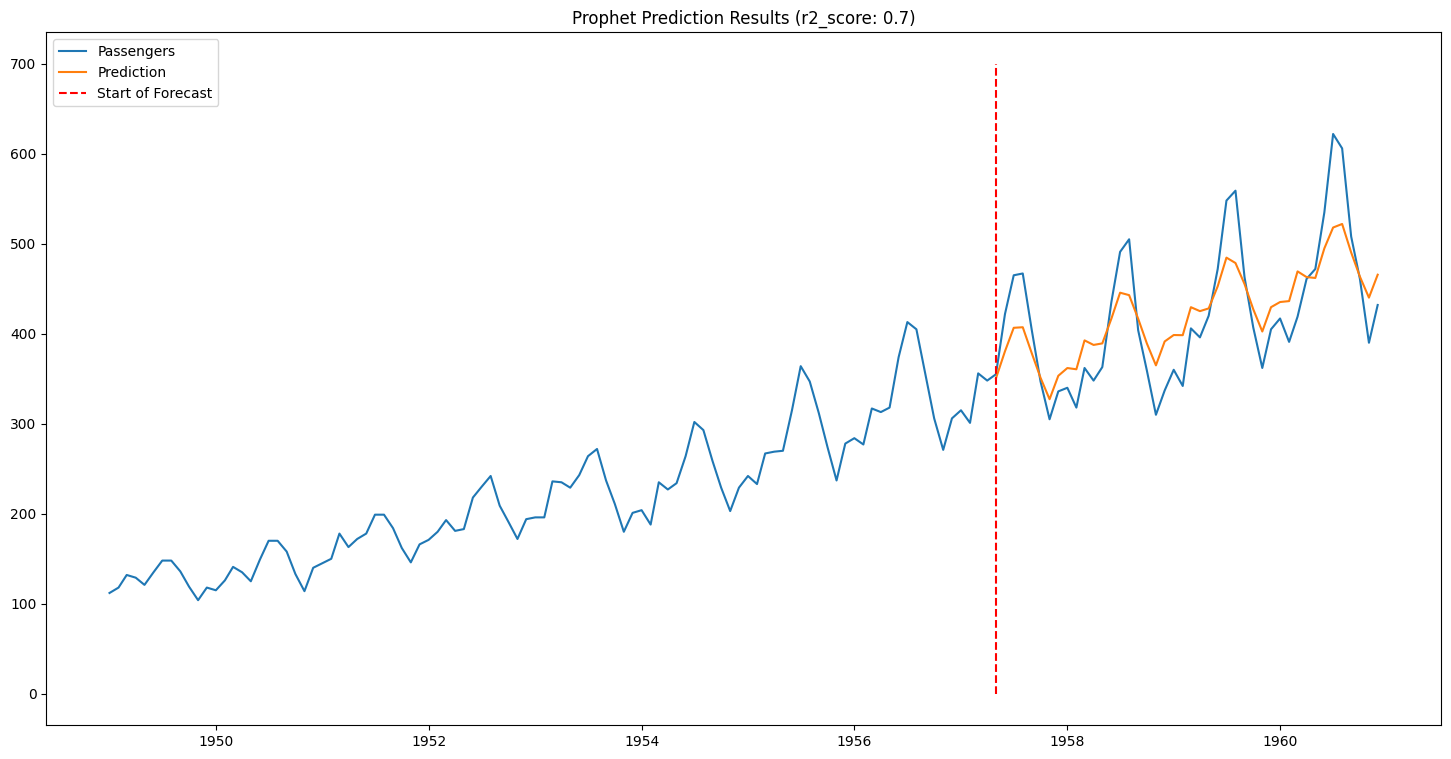

In [43]:
""" Prophet 시각화 """
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(data.index, data.values, label = 'Passengers') ### 기존 데이터 시각화
ax.plot(test.index, Prophet_test_pred, label = 'Prediction') ### test 예측 결과 시각화 

ax.vlines(datetime.datetime.strptime('1957-05-01','%Y-%m-%d'), ymin=0, ymax=700, linestyle='--', color='r', label='Start of Forecast') ### train/test 분리시점 시각화
ax.legend(loc='upper left') ### 범례 지정
plt.title(f'Prophet Prediction Results (r2_score: {np.round(r2_score(test, Prophet_test_pred), 2)})') ### Figure 제목 지정
plt.show()

#### **2.5 모델 간 비교**

In [44]:
""" 모델 적합 """

""" 구간평균법 """
MA_N = 5
MA_train_flatten = train.values.flatten()
MA_train_pred = np.convolve(MA_train_flatten, np.ones(MA_N) / MA_N, 'valid') 

MA_before_value = np.empty((MA_N-1)) 
MA_before_value[:] = np.nan 
MA_train_pred = np.concatenate((MA_before_value, MA_train_pred), axis=0) 

MA_train_df = pd.DataFrame(MA_train_pred, index=train.index, columns=[f'MA_{MA_N}'])
MA_train_df = pd.concat([train, MA_train_df], axis=1)

MA_pred = [MA_train_pred[-1]] * len(test) 
MA_test_df = pd.DataFrame(MA_pred, index=test.index, columns=[f'MA_{MA_N}'])
MA_test_df = pd.concat([test, MA_test_df], axis=1)

MA_test_pred = MA_test_df[f"MA_{MA_N}"]

####################################################################################################################################################################################

""" 단순지수평활법 """
SES_initial_df = pd.DataFrame([np.nan], index=[0], columns=['passengers'])
SES_train_df = pd.concat([SES_initial_df, train], axis=0)
SES_train_df['Level'] = np.nan
SES_train_df['Forecast'] = np.nan
SES_L_0 = np.mean(train)
SES_train_df.loc[0, 'Level'] = SES_L_0

SES_alpha = 0.9
for i in range(len(SES_train_df)):
    
    if i == 0: 
        continue
    
    SES_current_time = SES_train_df.index[i] 
    SES_previous_time = SES_train_df.index[i-1] 
    
    SES_x = SES_train_df.loc[SES_current_time, 'passengers'] 
    SES_L_prev = SES_train_df.loc[SES_previous_time, 'Level'] 
    SES_train_df.loc[SES_current_time, 'Level'] = (SES_alpha)*SES_x + (1-SES_alpha)*SES_L_prev 
    
SES_L_pred = SES_train_df.iloc[-1]['Level'] 
SES_test_pred = [SES_L_pred] * len(test) 
SES_test_df = pd.DataFrame(data=SES_test_pred, 
                             index=test.index, 
                             columns=[f'SES_{SES_alpha}'])

SES_test_pred = SES_test_df[f"SES_{SES_alpha}"]

####################################################################################################################################################################################

""" 이중지수평활법 """
DES_reg = train.reset_index()
DES_reg_x = pd.DataFrame(DES_reg.index, columns=['time']) 
DES_reg_y = DES_reg['passengers'] 

DES_reg_x = sm.add_constant(DES_reg_x) 
DES_reg_model = sm.OLS(DES_reg_y, DES_reg_x) 
DES_results = DES_reg_model.fit() 

DES_L_0, DES_B_0 = DES_results.params

DES_initial_df = pd.DataFrame(np.zeros(1), index=[0], columns=['passengers'])
DES_train_df = pd.concat([DES_initial_df, train], axis=0)

DES_train_df['Level'] = np.nan
DES_train_df['Trend'] = np.nan
DES_train_df['Forecast'] = np.nan

DES_train_df.loc[0, 'Level'] = DES_L_0
DES_train_df.loc[0, 'Trend'] = DES_B_0

DES_alpha = 0.16 
DES_beta = 0.1 

for i in range(len(DES_train_df)):
    
    if i == 0: 
        continue
    
    DES_current_time = DES_train_df.index[i] 
    DES_previous_time = DES_train_df.index[i-1] 

    DES_x = DES_train_df.loc[DES_current_time, 'passengers'] 
    DES_L_prev = DES_train_df.loc[DES_previous_time, 'Level'] 
    DES_T_prev = DES_train_df.loc[DES_previous_time, 'Trend'] 
    
    DES_train_df.loc[DES_current_time, 'Level'] = DES_alpha*DES_x + (1-DES_alpha)*(DES_L_prev+DES_T_prev)
    DES_train_df.loc[DES_current_time, 'Trend'] = DES_beta*(DES_train_df.loc[DES_current_time, 'Level']-DES_L_prev) + (1-DES_beta)*(DES_T_prev)
    
DES_L_Pred = DES_train_df.iloc[-1]['Level']
DES_T_Pred = DES_train_df.iloc[-1]['Trend']
DES_test_pred = [DES_L_Pred + i*DES_T_Pred for i in range(len(test))]

DES_test_df = pd.DataFrame(data=DES_test_pred, 
                             index=test.index, 
                             columns=['DES'])
DES_test_pred = DES_test_df["DES"]

####################################################################################################################################################################################

""" Addictive 홀트-윈터 지수평활법 """
HW_ADD_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(optimized=True)
HW_ADD_test_pred = HW_ADD_model.forecast(len(test)) 

####################################################################################################################################################################################

""" Multiplicative 홀트-윈터 지수평활법 """
HW_MUL_model = ExponentialSmoothing(train, trend='mul', seasonal='mul').fit(optimized=True)
HW_MUL_test_pred = HW_MUL_model.forecast(len(test))

In [45]:
""" 모델 간 비교 """
print('-'*55)
print('Moving Average (N = 5)')
print(f'MSE: {np.round(mean_squared_error(test, MA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,MA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, MA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, MA_test_pred), 2)}')

print('-'*55)
print('Simple Exponential Smoothing (alpha = 0.9)')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test, SES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, SES_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred), 2)}')

print('-'*55)
print('Double Exponential Smoothing (alpha = 0.16, beta = 0.1)')
print(f'MSE: {np.round(mean_squared_error(test, DES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,DES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, DES_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, DES_test_pred), 2)}')

print('-'*55)
print('Additive Holt-Winter Exponential Smoothing')
print(f'MSE: {np.round(mean_squared_error(test, HW_ADD_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test, HW_ADD_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_ADD_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, HW_ADD_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_ADD_test_pred), 2)}')

print('-'*55)
print('Multiplicative Holt-Winter Exponential Smoothing')
print(f'MSE: {np.round(mean_squared_error(test, HW_MUL_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test, HW_MUL_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_MUL_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, HW_MUL_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_MUL_test_pred), 2)}')

print('-'*55)
print(f'ARIMA {ARIMA_optimal[0][0]}')
print(f'MSE: {np.round(mean_squared_error(test, ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, ARIMA_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')

print('-'*55)
print(f'SARIMA {SARIMA_optimal[0][0][0]},{SARIMA_optimal[0][0][1]}')
print(f'MSE: {np.round(mean_squared_error(test, SARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, SARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA_test_pred), 2)}')

print('-'*55)
print('Prophet')
print(f'MSE: {np.round(mean_squared_error(test, Prophet_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,Prophet_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, Prophet_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, Prophet_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, Prophet_test_pred), 2)}')

-------------------------------------------------------
Moving Average (N = 5)
MSE: 15034.77
RMSE: 122.62
MAE: 97.8
MAPE: 20.98
R2 score: -1.57
-------------------------------------------------------
Simple Exponential Smoothing (alpha = 0.9)
MSE: 11144.69
RMSE: 105.57
MAE: 79.69
MAPE: 16.88
R2 score: -0.91
-------------------------------------------------------
Double Exponential Smoothing (alpha = 0.16, beta = 0.1)
MSE: 5555.17
RMSE: 74.53
MAE: 54.65
MAPE: 11.96
R2 score: 0.05
-------------------------------------------------------
Additive Holt-Winter Exponential Smoothing
MSE: 1130.94
RMSE: 33.63
MAE: 24.88
MAPE: 5.4
R2 score: 0.81
-------------------------------------------------------
Multiplicative Holt-Winter Exponential Smoothing
MSE: 1243.71
RMSE: 35.27
MAE: 30.56
MAPE: 7.48
R2 score: 0.79
-------------------------------------------------------
ARIMA (1, 1, 2)
MSE: 14889.77
RMSE: 122.02
MAE: 97.19
MAPE: 20.84
R2 score: -1.55
---------------------------------------------------

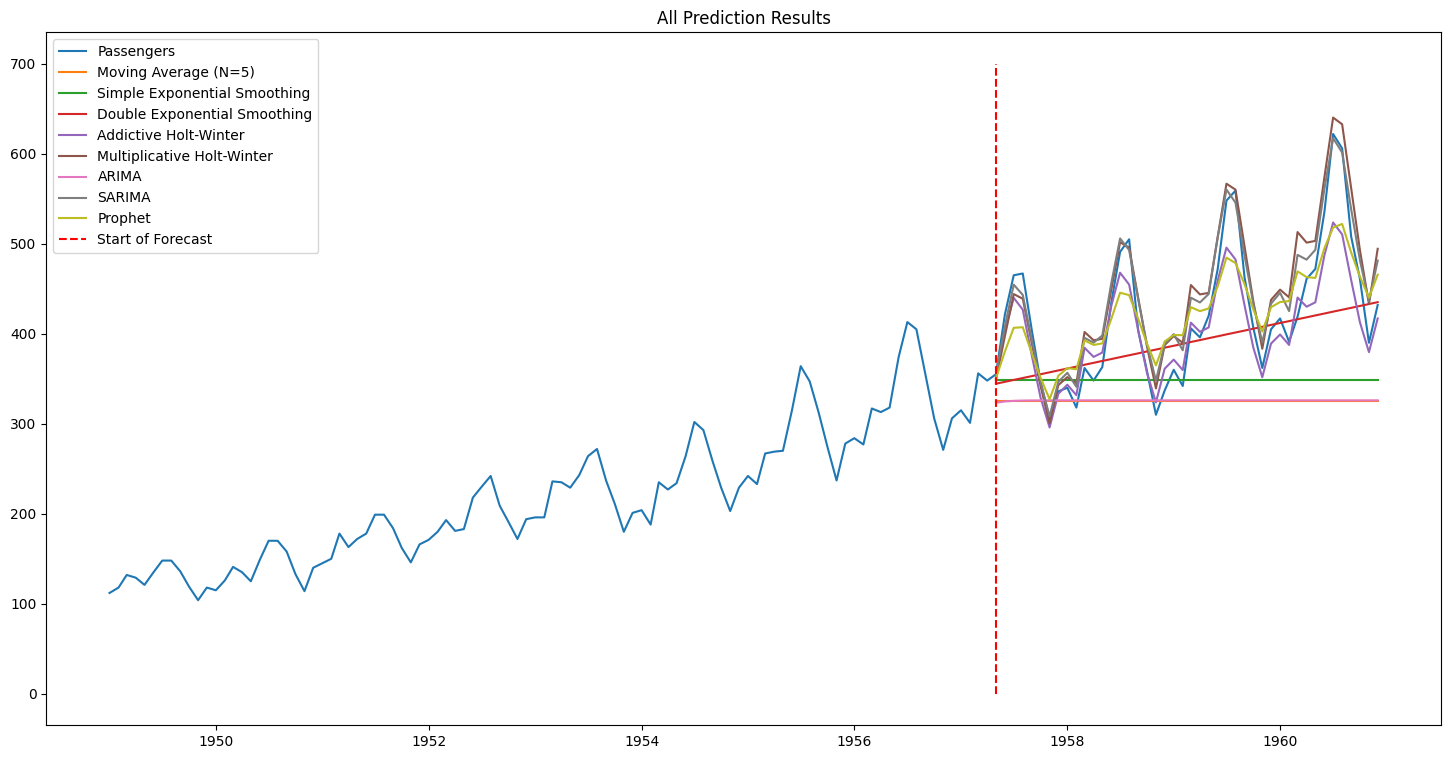

In [48]:
""" 전체 예측 결과 시각화 """
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(data.index, data.values, label='Passengers') ### 기존 데이터 시각화
ax.plot(test.index, MA_test_pred, label='Moving Average (N=5)') ### 구간평균법
ax.plot(test.index, SES_test_pred, label='Simple Exponential Smoothing') ### 단순지수평활법
ax.plot(test.index, DES_test_pred, label='Double Exponential Smoothing') ### 이중지수평활법
ax.plot(test.index, HW_ADD_test_pred, label='Addictive Holt-Winter') ### Addictive 홀트-윈터 
ax.plot(test.index, HW_MUL_test_pred, label='Multiplicative Holt-Winter') ### Multiplicative 홀트-윈터 
ax.plot(test.index, ARIMA_test_pred, label='ARIMA') ### ARIMA
ax.plot(test.index, SARIMA_test_pred, label='SARIMA') ### SARIMA
ax.plot(test.index, Prophet_test_pred, label='Prophet') ### Prophet

ax.vlines(datetime.datetime.strptime('1957-05-01','%Y-%m-%d'), ymin=0, ymax=700, linestyle='--', color='r', label='Start of Forecast') ### train/test 분리시점 시각화
ax.legend(loc='upper left') ### 범례 지정
plt.title(f'All Prediction Results') ### Figure 제목 지정
plt.show()

# **EOD**